In [1]:
%pip install torch
%pip install cmake
%pip install swig
%pip install gym
%pip install 'pettingzoo[all]'
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_v3, simple_spread_v3
import gym

class DeepQNetwork(nn.Module):
    # 멤버 객체 설정 및 저장
    def __init__(self, state_dims, c_h_sizes, v_h_sizes, a_h_sizes, n_actions, lr=0.003):
        super(DeepQNetwork, self).__init__()
        self.state_dims = state_dims
        self.c_h_sizes = c_h_sizes
        self.v_h_sizes = v_h_sizes
        self.a_h_sizes = a_h_sizes
        self.n_actions = n_actions
        self.c_layers = nn.ModuleList()
        self.v_layers = nn.ModuleList()
        self.a_layers = nn.ModuleList()

        self.c_layers.append(nn.Linear(*state_dims, c_h_sizes[0]))
        self.c_layers.append(nn.ReLU())
        for i in range(len(c_h_sizes)-1):
            self.c_layers.append(nn.Linear(c_h_sizes[i], c_h_sizes[i+1]))
            self.c_layers.append(nn.ReLU())
        
        self.v_layers.append(nn.Linear(c_h_sizes[-1], v_h_sizes[0]))
        self.v_layers.append(nn.ReLU())
        for i in range(len(v_h_sizes)-1):
            self.v_layers.append(nn.Linear(v_h_sizes[i], v_h_sizes[i+1]))
            self.v_layers.append(nn.ReLU())
        self.v_layers.append(nn.Linear(v_h_sizes[-1], 1))

        self.a_layers.append(nn.Linear(c_h_sizes[-1], a_h_sizes[0]))
        self.a_layers.append(nn.ReLU())
        for i in range(len(a_h_sizes)-1):
            self.a_layers.append(nn.Linear(a_h_sizes[i], a_h_sizes[i+1]))
            self.a_layers.append(nn.ReLU())
        self.a_layers.append(nn.Linear(a_h_sizes[-1], n_actions))

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    # state를 받아서 각 action에 대한 예상 Q-value를 벡터로 반환 : Q(s)[a]
    def forward(self, x):
        for layer in self.c_layers:
            x = layer(x)
        y = x.clone()
        for layer in self.v_layers:
            x = layer(x)
        for layer in self.a_layers:
            y = layer(y)
        mean_y = torch.mean(y, dim=-1, keepdim=True)
        # print(f"x.size={x.size()}")
        # print(f"y.size={y.size()}")
        # print(f"mean_y.size={mean_y.size()}")
        out = x + (y - mean_y)
        # print(f"out.size()={out.size()}")
        # print(out)
        return out


class DuelingDeepQLearningAgent:
    def __init__(self, state_dims, n_actions, gamma=0.99, eps=1.0, 
                 a=None, lr=0.003, c_h_sizes=[64], v_h_sizes=[32, 32], a_h_sizes=[32, 32], 
                 batch_size=64, mem_size=50000):
        self.state_dims = state_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.eps = eps
        self.a = a
        self.lr = lr
        self.v_h_sizes = v_h_sizes
        self.a_h_sizes = a_h_sizes
        self.c_h_sizes = c_h_sizes
        self.batch_size = batch_size
        self.mem_size = mem_size

        self.Q_eval = DeepQNetwork(state_dims, c_h_sizes, v_h_sizes, a_h_sizes, n_actions, lr=lr)

        self.action_space = gym.spaces.Discrete(n_actions)
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *state_dims), dtype=np.float32)
        self.action_memory = -1 * np.ones(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_dims), dtype=np.float32)
        self.termination_memory = np.zeros(self.mem_size, dtype=np.bool_)
        self.truncation_memory = np.zeros(self.mem_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, next_state, terminated, truncated):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.termination_memory[index] = terminated
        self.truncation_memory[index] = truncated
        self.mem_cntr += 1
    
    def choose_action(self, state):
        if np.random.random() < self.eps:
            # action = np.random.choice(self.action_space).item()
            action = self.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.Tensor(state, device=self.Q_eval.device)
                Q_vals = self.Q_eval.forward(state)
                action = torch.argmax(Q_vals).item()
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.mem_size)
        if self.a is not None:
            self.eps = self.a / (self.a + self.mem_cntr)
        batch = np.random.choice(max_mem, size=self.batch_size, replace=False)
        batch_index = torch.arange(self.batch_size, dtype=torch.int32)
        
        state_batch = torch.Tensor(self.state_memory[batch], device=self.Q_eval.device).float()
        action_batch = torch.Tensor(self.action_memory[batch], device=self.Q_eval.device).int()
        reward_batch = torch.Tensor(self.reward_memory[batch], device=self.Q_eval.device).float()
        next_state_batch = torch.Tensor(self.next_state_memory[batch], device=self.Q_eval.device).float()
        termination_batch = torch.Tensor(self.termination_memory[batch], device=self.Q_eval.device).bool()
        truncation_batch = torch.Tensor(self.truncation_memory[batch], device=self.Q_eval.device).bool()

        q = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(next_state_batch)
        q_next[termination_batch] = 0.0
        q_next[truncation_batch] = 0.0
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=-1)[0]
        loss = self.Q_eval.loss(q_target.detach(), q).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
    

if __name__ == '__main__':
    # PettingZoo 환경 생성
    env = simple_spread_v3.parallel_env(render_mode="human")
    env.reset()
    n_agents = env.num_agents
    state_dims = env.observation_space(env.possible_agents[0]).shape
    n_actions = env.action_space(env.possible_agents[0]).n

    # 변수 선언
    agent_instances = {agent:DuelingDeepQLearningAgent(state_dims=state_dims, n_actions=n_actions, gamma=0.9, 
                                                a=60000, lr=0.0003, c_h_sizes=[64], v_h_sizes=[32, 32], a_h_sizes=[32, 32], mem_size=40000) for agent in env.agents}
    score_history, eps_history = [], []
    n_episodes = 44000
    stop_learning = 40000

    # 게임을 여러 차례 돌린다
    for episode in range(n_episodes):
        # 변수 선언
        obs, infos = env.reset()
        scores = {agent:0 for agent in env.agents}
        dones = {agent:False for agent in env.agents}
        epsilons = {agent:agent_instances[agent].eps for agent in env.agents}
        # 게임 종료 전까지 s, a, r, s' 및 종료 정보 생성, 학습 및 기록
        while env.agents:  # 모든 에이전트가 종료되기 전까지
            actions = {agent:agent_instances[agent].choose_action(obs[agent]) for agent in env.agents}
            next_obs, rewards, terminations, truncations, _ = env.step(actions)
            for agent in env.agents:
                agent_instances[agent].store_transition(obs[agent], actions[agent], rewards[agent], next_obs[agent], 
                                                        terminations[agent], truncations[agent])
                if episode < stop_learning:
                    agent_instances[agent].learn()
                else:
                    agent_instances[agent].eps = 0.0
                scores[agent] += rewards[agent]
            obs = next_obs
        # 최종 점수 및 epsilon 기록
        score_history.append(scores)
        eps_history.append(epsilons)
        if episode % 100 == 0:
            print('episode:', episode, 'scores:', scores, 'epsilons:', epsilons)
    env.close()

episode: 0 scores: {'agent_0': -21.136427976236345, 'agent_1': -20.636427976236345, 'agent_2': -21.136427976236345} epsilons: {'agent_0': 1.0, 'agent_1': 1.0, 'agent_2': 1.0}
episode: 100 scores: {'agent_0': -27.18741701248904, 'agent_1': -27.18741701248904, 'agent_2': -27.18741701248904} epsilons: {'agent_0': 0.9615384615384616, 'agent_1': 0.9615384615384616, 'agent_2': 0.9615384615384616}
episode: 200 scores: {'agent_0': -31.484834811955142, 'agent_1': -32.984834811955146, 'agent_2': -32.984834811955146} epsilons: {'agent_0': 0.9259259259259259, 'agent_1': 0.9259259259259259, 'agent_2': 0.9259259259259259}
episode: 300 scores: {'agent_0': -38.86431278416784, 'agent_1': -37.86431278416784, 'agent_2': -38.86431278416784} epsilons: {'agent_0': 0.8928571428571429, 'agent_1': 0.8928571428571429, 'agent_2': 0.8928571428571429}


KeyboardInterrupt: 

: 

In [16]:
import matplotlib.pyplot as plt

# Learning curve 그리기
def plot_learning_curve(score_history, eps_history, filename, lines=None):
    fig=plt.figure()
    ax1=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    x = [i+1 for i in range(len(score_history))]
    y1 = [score_history[i]['agent_0'] for i in range(len(score_history))]
    y2 = [np.nan] * 50 + [np.mean(y1[i-50:i+50]) for i in range(50, len(eps_history)-50)] + [np.nan] * 50
    y3 = [eps_history[i]['agent_0'] for i in range(len(eps_history))]

    ax1.plot(x, y1, color="pink")
    ax1.plot(x, y2, color="red")
    ax2.plot(x, y3, color="blue")
    
    ax1.set_xlabel("# episodes", color="black")
    ax1.set_ylabel("Epsilons / scores", color="black")
    ax1.tick_params(axis='x', colors="black")
    ax1.tick_params(axis='y', colors="black")

    plt.savefig(filename)

MADDQL_simple_spread_v3_gamma=0.900_a=60000_lr=0.00030_vhs=[32, 32]_ahs=[32, 32]_bs=64_ms=80000_n_episodes=88000.png


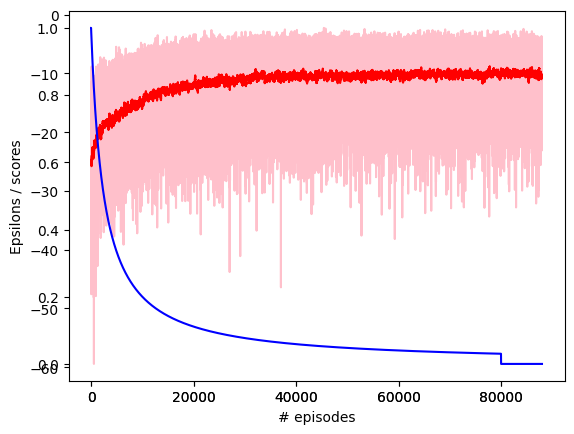

In [20]:
a = agent_instances['agent_0']
filename = f"MADDQL_{env}_gamma={a.gamma:.3f}_" + (f"a={a.a}" if a.a is not None else f"eps={a.eps}") \
    + f"_lr={a.lr:.5f}_vhs={a.v_h_sizes}_ahs={a.a_h_sizes}_bs={a.batch_size}_ms={a.mem_size}_n_episodes={n_episodes}.png"
print(filename)
plot_learning_curve(score_history, eps_history, filename)